In [1]:
from common import *

from matplotlib.ticker import MultipleLocator

import water
import moles

tmin = 0.5
dt   = 0.1

for f in glob.glob("lv/dat/*"):
    os.remove(f)

In [2]:
def write_csv(gas,ts,hs):
    X = np.array([ts,hs]).T 
    head = "T [K] , delta-h [J kg-1]"
    fpath = "lv/dat/%s.csv"%gas 

    np.savetxt(fpath, X, fmt="%.9e", delimiter=',', header=head)

In [3]:
# Coker (2007) gases (vapourisation only)
data_vap = np.loadtxt("lv/web/coker2007_appendixC.csv", delimiter=',', dtype=str, skiprows=1)

table = moles.read_elements()

# Row by row
for row in data_vap:

    # get values
    formula = row[0]
    name    = row[1]
    fit_A   = float(row[2])
    fit_T   = float(row[3])
    fit_n   = float(row[4])
    Tmin    = float(row[5])
    Tmax    = float(row[6])

    # define fit 
    def _fit(t:float):
        t = max(t, Tmin)
        t = min(t, Tmax)
        out = fit_A * (1 - t/fit_T)**fit_n # kJ/mol
        out = out * 1e3 / moles.mmw_from_formula(formula, table)  # J/kg
        return out 
    
    t_arr = np.arange(tmin, Tmax+dt, dt)
    
    h_arr = [_fit(t) for t in t_arr]
    write_csv(formula, t_arr, h_arr)


In [4]:
# Water
t_arr = np.arange(tmin, water.T_crit, dt)[:-1]
t_arr = np.concatenate((t_arr, [water.T_crit]))
h_arr = [water.delta_both(t) for t in t_arr]
write_csv("H2O",t_arr, h_arr)

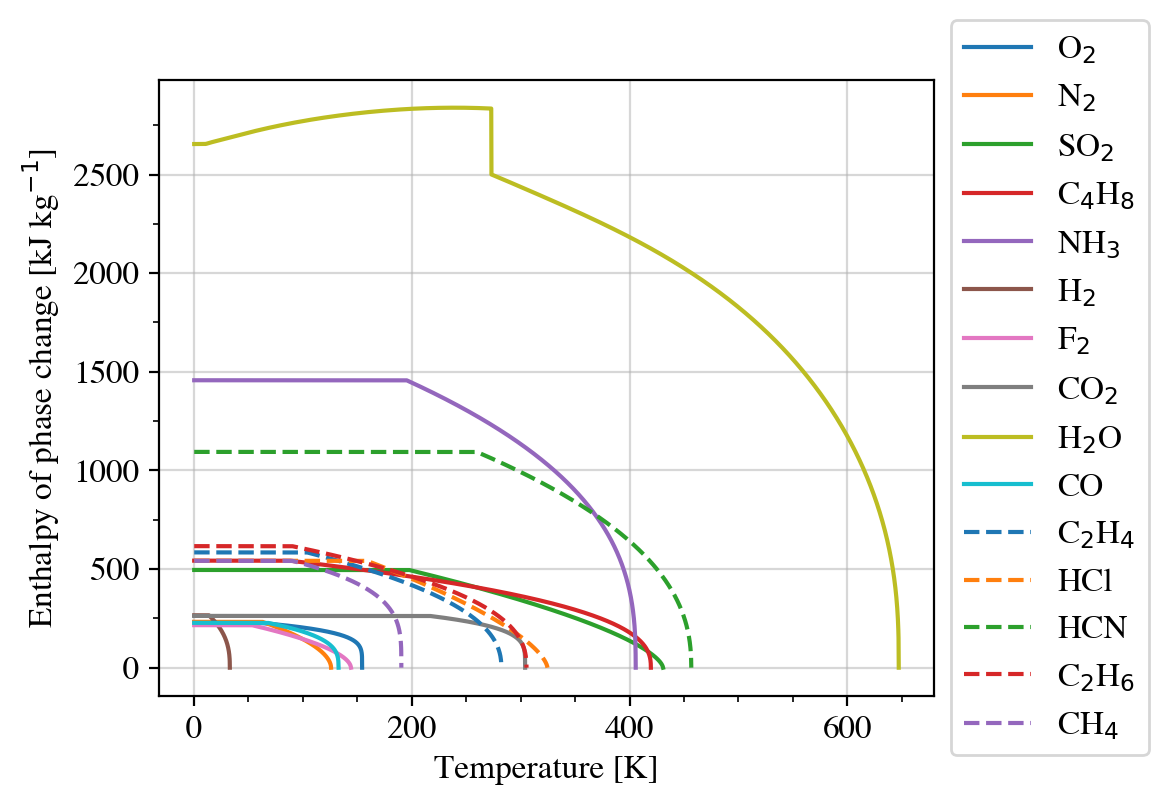

In [7]:
plt.close("all")


fig,ax = plt.subplots(1,1, figsize=(5,4))

files = glob.glob("lv/dat/*.csv")

for i,f in enumerate(files):
    form = moles.formula_from_path(f)
    data = np.loadtxt(f, delimiter=',').T

    ls='solid'
    if i > 9:
        ls='dashed'
    if i > 18:
        ls='dotted'

    ax.plot(data[0], data[1]/1000, label=pretty_name(form), ls=ls)

ax.set(xlabel="Temperature [K]", ylabel="Enthalpy of phase change [kJ kg$^{-1}$]")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(250))

ax.grid(zorder=0, alpha=0.5)

fig.savefig("lv/all.pdf", bbox_inches='tight')
plt.show()